In [1]:
import pyrosetta.rosetta
from pyrosetta import *
from pyrosetta.rosetta import *
import sys, os
from pyrosetta import PyMOLMover
import random
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt

In [2]:
pyrosetta.init()

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.12+release.5ecebca-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.12+release.5ecebca5ecebcadacdf48ede3c1981444601bf1cd47ce0d 2018-03-23T13:02:49] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r174 2018.12+release.5ecebca 5ecebcadacdf48ede3c1981444601bf1cd47ce0d http://www.pyrosetta.org 2018-03-23T13:02:49
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.12+release.5ecebca-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=-1060743217 seed_offset=0 real_seed=-1060743217
core.init.random: RandomGenerat

In [3]:
sfxn = pyrosetta.get_fa_scorefxn()

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard res

In [6]:
## still isnt working? used the ip that appears in PyMOL.
my_ip = os.environ["my_ip"]
pmm = PyMOLMover(my_ip,65000)

In [15]:
def MonteCarlo(pose, ntrials, simname, new_pose = False):
    """
    """
    if new_pose == True:
        dump_pdb(pose, simname+"_init.pdb") # save initial pose to multimodel pdb
    scores = np.zeros((ntrials+1)) # empty array for score after each 
                                         # MC trial, including the initial score
    begin_pose = Pose()
    begin_pose.assign(pose)
    i = sfxn(begin_pose) # initial score
    scores[0] = i # adding ititial score to "scores" array    
    for trial in range(ntrials):
        init_pose = Pose()     #{defining initial 
        init_pose.assign(pose) # pose}
        start = sfxn(init_pose) # score at beggining of MC trial
        for resi in range(len(pose.residues)): # so all residues get a change
            init_phi = pose.phi(resi+1) # initial phi angle of the residue
            init_psi = pose.psi(resi+1) # initial psi angle of the residue
            phi = random.gauss(init_phi, 25) #{ random angle chosen from a gaussian 
            psi = random.gauss(init_psi, 25) # distribution of angles with the initial
                                             # angle as the mean and a 25 degree stdev}
            pose.set_phi(resi+1, phi) # setting phi to random angle
            pose.set_psi(resi+1, psi) # setting psi to random angle
        fin_pose = Pose()
        fin_pose.assign(pose)
        finish = sfxn(fin_pose) # score at end of MC trial
        scores[trial+1] = finish
        #To allow if statment for selecting lowest-scoring pose to work:
        truth = np.zeros((scores.shape))
        for j in scores:
            if finish<=j:
                truth[:] = 0
            else:
                truth[:] = 1
        # The if statement:
        if all(k == 0 for k in truth)==True:
            if finish<i:
                print "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
                print "found low!!!", " The score is:", finish, "*******"
                low_pose = Pose()
                low_pose.assign(pose)
                dump_pdb(pose, simname+"_low.pdb")
            else: 
                print "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
                print "initial was lowest scoring:", i
                low_pose = begin_pose
        else:
            dump_pdb(fin_pose, simname+"_"+str(trial)+".pdb")
        dE = finish-start
        if dE<0:
            P = 1
        if dE>0:
            P = np.exp(-dE) #score should be in units of kT and typical
                            # temp is 1 kT (double check this)
        chosen = choice([0,1],None,p=[1-P,P])
        poses = [init_pose,fin_pose]
        next_pose = poses[chosen]
        next_pose.assign(poses[chosen])
    plt.plot(range(ntrials+1),scores)
    plt.show()
    return scores, fin_pose, low_pose

In [19]:
pose = pose_from_pdb("./testing_new_rosetta_compile/pR_9.pdb")
ntrials = 100
simname = "MC_pR9"

core.import_pose.import_pose: File './testing_new_rosetta_compile/pR_9.pdb' automatically determined to be of type PDB
core.chemical: [ WARNING ] Patch N_Methylation implies it can apply to residue type RYS, but actually applying it fails.
core.chemical: [ WARNING ]    You may want to check your patch definitions.
core.chemical: [ WARNING ] Patch N_Methylation implies it can apply to residue type DRYS, but actually applying it fails.
core.chemical: [ WARNING ]    You may want to check your patch definitions.
core.chemical: [ WARNING ] Patch N_Methylation implies it can apply to residue type DRYS, but actually applying it fails.
core.chemical: [ WARNING ]    You may want to check your patch definitions.
core.chemical: [ WARNING ] Patch N_Methylation implies it can apply to residue type DRYS, but actually applying it fails.
core.chemical: [ WARNING ]    You may want to check your patch definitions.
core.chemical: [ WARNING ] Patch N_Methylation implies it can apply to residue type DRYS, 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
initial was lowest scoring: 1033.23528195


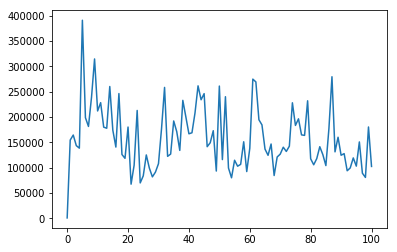

In [20]:
score, fin_pose, low_pose = MonteCarlo(pose,ntrials,simname,False)

In [21]:
print score.min()
# print score

1033.23528195


In [22]:
print fin_pose
print sfxn(fin_pose)

PDB file name: ./testing_new_rosetta_compile/pR_9.pdb
Total residues:235
Sequence: MGGGDLDASDYTGVSFWLVTAALLASTVFFFVERDRVSAKWKTSLTVSGLVTGIAFWHYMYMRGVWIETGDSPTVFRYIDWLLTVPLLICEFYLILAAATNVAGSLFKKLLVGSLVMLVFGYMGEAGIMAAWPAFIIGCLAWVYMIYELWAGEGKSACNTASPAVQSAYNTMMYIIIFGWAIYPVGYFTGYLMGDGGSALNLNLIYNLADFVNXILFGLIIWNVAVKESSNAPGG
Fold tree:
FOLD_TREE  EDGE 1 235 -1 
102534.810431


In [23]:
print low_pose
print sfxn(low_pose)

PDB file name: ./testing_new_rosetta_compile/pR_9.pdb
Total residues:235
Sequence: MGGGDLDASDYTGVSFWLVTAALLASTVFFFVERDRVSAKWKTSLTVSGLVTGIAFWHYMYMRGVWIETGDSPTVFRYIDWLLTVPLLICEFYLILAAATNVAGSLFKKLLVGSLVMLVFGYMGEAGIMAAWPAFIIGCLAWVYMIYELWAGEGKSACNTASPAVQSAYNTMMYIIIFGWAIYPVGYFTGYLMGDGGSALNLNLIYNLADFVNXILFGLIIWNVAVKESSNAPGG
Fold tree:
FOLD_TREE  EDGE 1 235 -1 
1033.23528195
